# Amazon Fine Food Reviews Analysis

##  [1]. Reading Data

### [1.1] Loading the data


In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!ls /content/drive/My\ Drive/Colab\ Notebooks

 database.sqlite  'Logistic Regression.ipynb'   RF.ipynb
 DT.ipynb	   NB.ipynb		        SVM.ipynb
 KNN.ipynb	   Reviews.csv		        Untitled2.ipynb


In [0]:
import pandas as pd

In [0]:
data=pd.read_csv('/content/drive/My Drive/Colab Notebooks/Reviews.csv')

In [0]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [0]:
import sqlite3

In [0]:
conn=sqlite3.connect('/content/drive/My Drive/Colab Notebooks/database.sqlite')

In [0]:
filter_data=pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """,conn)

In [0]:
def partition (x):
  if x<3:
    return 0
  return 1

In [0]:
actualscore = filter_data['Score']
positivenegative = actualscore.map(partition)
filter_data['Score']= positivenegative
print('Nomber of data points in our data',filter_data.shape)
filter_data.head(5)


Nomber of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", conn)

In [0]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [0]:
display['COUNT(*)'].sum()

393063

# [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", conn)
print(display.shape)
display.head()

(5, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [0]:
#Sorting data according to time in ascending order
sorted_data=filter_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filter_data['Id'].size*1.0)*100

69.25890143662969

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", conn)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

### [3.1]. Preprocessing Review Text

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I can't believe that you can actually buy Coke products on Amazon!<br /><br />If I was going to order any soft drink online, it would be Diet Coke with Lime.  The lime improves the taste of Diet Coke signifigantally and makes the aftertaste (from the artificial sweetener) much less noticeable.  Coke has quite intelligently taken  one of the mixes that many beverage-drinkers have been enjoying for years and made it available as a consistently-mixed, no knife (to peel the lime) needed version!
I bought some of this tea when I was in Seattle and I have been dying to get more.  It really is the best tea I have ever had. 

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I can't believe that you can actually buy Coke products on Amazon!If I was going to order any soft drink online, it would be Diet Coke with Lime.  The lime improves the taste of Diet Coke signifigantally and makes the aftertaste (from the artificial sweetener) much less noticeable.  Coke has quite intelligently taken  one of the mixes that many beverage-drinkers have been enjoying for years and made it available as a consistently-mixed, no knife (to peel the lime) needed version!
I bought some of this tea when I was in Seattle and I have been dying to get more.  It really is the best tea I have ever had.  It is great

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I bought some of this tea when I was in Seattle and I have been dying to get more.  It really is the best tea I have ever had.  It is great hot or cold.


In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [02:24<00:00, 2512.75it/s]


In [0]:
preprocessed_reviews[1500]

'bought tea seattle dying get really best tea ever great hot cold'

## [4] Featurization

### [4.1] BAG OF WORDS

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaa', 'aaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaa']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (364171, 116756)
the number of unique words  116756


### [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aaa', 'aaaaa', 'aaah', 'aafco', 'ab', 'aback', 'abandon', 'abandoned', 'abbey']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (364171, 203034)
the number of unique words including both unigrams and bigrams  203034


# Applying Multinomial Naive Bayes

## [5.1] Applying Naive Bayes on BOW

In [0]:
X=preprocessed_reviews[0:100000]
y=np.array(final['Score'][0:100000])


In [0]:
#Breaking into Train and test
X_train = X[:60000]
X_cv = X[60000:80000]
X_test = X[80000:]
y_train = np.array(final['Score'][:60000])
y_cv = np.array(final['Score'][60000:80000])
y_test = np.array(final['Score'][80000:100000])

In [0]:
len(y_test)

20000

In [0]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2)


count_vect = CountVectorizer()
count_vect.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train =count_vect.transform(X_train)
X_cv = count_vect.transform(X_cv)
X_test = count_vect.transform(X_test)

#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)

#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

X_cv = preprocessing.normalize(X_cv)
print("CV Data Size :", X_cv.shape)

Train Data Size:  (60000, 45723)
Test Data Size:  (20000, 45723)
CV Data Size : (20000, 45723)


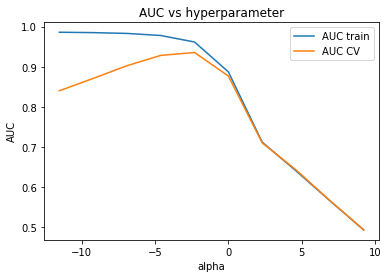

optimal alpha for which auc is maximum :  0.1


In [0]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
import math

alpha = [10000,1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001]

train_auc = []
cv_auc = []

for i in alpha:
    clf = MultinomialNB(alpha = i,class_prior=[0.5,0.5])
    clf.fit(X_train,y_train)
    prob_cv = clf.predict_proba(X_cv)[:,1]
    cv_auc.append(roc_auc_score(y_cv,prob_cv))
    prob_train = clf.predict_proba(X_train)[:,1]
    train_auc.append(roc_auc_score(y_train,prob_train))
optimal_alpha= alpha[cv_auc.index(max(cv_auc))]
alpha=[math.log(x) for x in alpha]

#plot auc vs alpha
x = plt.subplot( )
x.plot(alpha, train_auc, label='AUC train')
x.plot(alpha, cv_auc, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('alpha')
plt.ylabel('AUC')
x.legend()
plt.show()

print('optimal alpha for which auc is maximum : ',optimal_alpha)

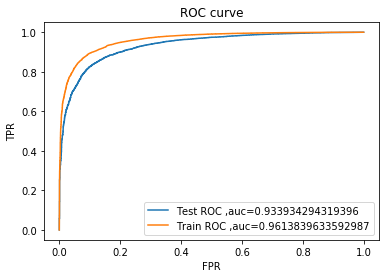

AUC on Test data is 0.933934294319396
AUC on Train data is 0.9613839633592987
---------------------------


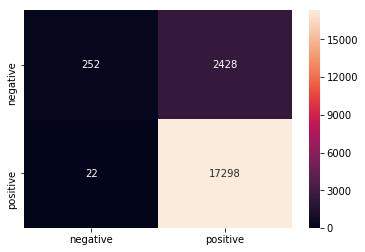

In [0]:
#Testing AUC on Test data
clf = MultinomialNB(alpha = optimal_alpha)
clf.fit(X_train,y_train)
pred_test = clf.predict_proba(X_test)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, pred_test)
pred_train = clf.predict_proba(X_train)[:,1]
fpr2,tpr2,thresholds2 = metrics.roc_curve(y_train,pred_train) 


#plot ROC curve
x = plt.subplot( )
x.plot(fpr1, tpr1, label ='Test ROC ,auc='+str(roc_auc_score(y_test,pred_test)))
x.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred_train)))
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
x.legend()
plt.show()

print("AUC on Test data is " +str(roc_auc_score(y_test,pred_test)))
print("AUC on Train data is " +str(roc_auc_score(y_train,pred_train)))

print("---------------------------")

# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred_test.round()), index=class_names, columns=class_names )
fig = plt.figure( )
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")



In [0]:
results=pd.DataFrame(columns=['Featuraization', 'Classifier' ,'alpha', 'Train-AUC', 'Test-AUC' ])
new = ['BOW','MultinomialNB',0.1,0.9613,0.9339]
results.loc[0] = new

### [5.1.1] Top 10 important features of positive class 

In [0]:
# Please write all the code with proper documentation
clf = MultinomialNB(alpha=0.1)
clf.fit(X_train,y_train)
features = clf.feature_log_prob_
feature_names = count_vect.get_feature_names()
negative_features = np.argsort(features[0])[::-1]
positive_features = np.argsort(features[1])[::-1]
print("Top 10 important features of positive class from BOW")
for i in list(positive_features[0:10]):
  print(feature_names[i])
    


Top 10 important features of positive class from BOW
not
great
good
like
tea
taste
product
love
one
flavor


### [5.1.2] Top 10 important features of negative class 

In [0]:
print("Top 10 important features of Negatit class from BOW")
for i in list(negative_features[0:10]):
  print(feature_names[i])

Top 10 important features of Negatit class from BOW
not
like
taste
product
would
one
good
flavor
no
tea


## [5.2] Applying Naive Bayes on TFIDF

In [0]:
tf_idf_vect = TfidfVectorizer( min_df=10)

#Breaking into Train, CV  and test
#Breaking into Train and test
X_train = X[:60000]
X_cv = X[60000:80000]
X_test = X[80000:]
y_train = np.array(final['Score'][:60000])
y_cv = np.array(final['Score'][60000:80000])
y_test = np.array(final['Score'][80000:100000])


tf_idf_vect.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train = tf_idf_vect.transform(X_train)
X_cv = tf_idf_vect.transform(X_cv)
X_test = tf_idf_vect.transform(X_test)

#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)

#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

X_cv = preprocessing.normalize(X_cv)
print("CV Data Size :", X_cv.shape)

Train Data Size:  (60000, 9597)
Test Data Size:  (20000, 9597)
CV Data Size : (20000, 9597)


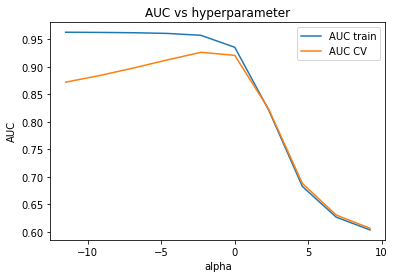

optimal alpha for which auc is maximum :  0.1


In [0]:
alpha = [10000,1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001]

train_auc = []
cv_auc = []

for i in alpha:
    clf = MultinomialNB(alpha = i,class_prior=[0.5,0.5])
    clf.fit(X_train,y_train)
    prob_cv = clf.predict_proba(X_cv)[:,1]
    cv_auc.append(roc_auc_score(y_cv,prob_cv))
    prob_train = clf.predict_proba(X_train)[:,1]
    train_auc.append(roc_auc_score(y_train,prob_train))
optimal_alpha= alpha[cv_auc.index(max(cv_auc))]
alpha=[math.log(x) for x in alpha]

#plot auc vs alpha
x = plt.subplot( )
x.plot(alpha, train_auc, label='AUC train')
x.plot(alpha, cv_auc, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('alpha')
plt.ylabel('AUC')
x.legend()
plt.show()

print('optimal alpha for which auc is maximum : ',optimal_alpha)

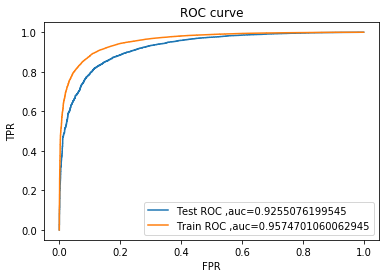

AUC on Test data is 0.9255076199545
AUC on Train data is 0.9574701060062945
---------------------------


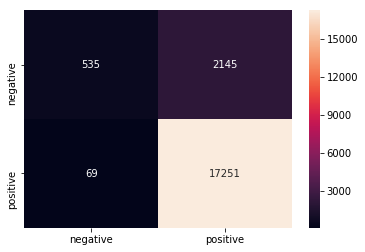

In [0]:
#Testing AUC on Test data
clf = MultinomialNB(alpha = optimal_alpha)
clf.fit(X_train,y_train)
pred_test = clf.predict_proba(X_test)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, pred_test)
pred_train = clf.predict_proba(X_train)[:,1]
fpr2,tpr2,thresholds2 = metrics.roc_curve(y_train,pred_train)

#plot ROC curve
x = plt.subplot( )
x.plot(fpr1, tpr1, label ='Test ROC ,auc='+str(roc_auc_score(y_test,pred_test)))
x.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred_train)))
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
x.legend()
plt.show()

print("AUC on Test data is " +str(roc_auc_score(y_test,pred_test)))
print("AUC on Train data is " +str(roc_auc_score(y_train,pred_train)))

print("---------------------------")

# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred_test.round()), index=class_names, columns=class_names )
fig = plt.figure( )
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

In [0]:
new = ['tf-idf','MultinomialNB',0.1,0.9574,0.9255]
results.loc[1] = new

### [5.2.1] Top 10 important features of positive class 

In [0]:
# Please write all the code with proper documentation
clf = MultinomialNB(alpha=0.1)
clf.fit(X_train,y_train)
features = clf.feature_log_prob_
feature_names = tf_idf_vect.get_feature_names()
negative_features = np.argsort(features[0])[::-1]
positive_features = np.argsort(features[1])[::-1]
print("Top 10 important features of positive class from TFIDF")
for i in list(positive_features[0:10]):
    print(feature_names[i])


Top 10 important features of positive class from TFIDF
not
great
tea
good
like
love
product
taste
flavor
one


### [5.2.2] Top 10 important features of negative class 

In [0]:
# Please write all the code with proper documentation
print("Top 10 important features of negative class from TFIDF")
for i in list(negative_features[0:10]):
    print(feature_names[i])

Top 10 important features of negative class from TFIDF
not
like
product
would
taste
one
flavor
no
good
tea


## Performance Table

In [0]:
results

,Featuraization,Classifier,alpha,Train-AUC,Test-AUC
0,BOW,MultinomialNB,0.1,0.9613,0.9339
1,tf-idf,MultinomialNB,0.1,0.9574,0.9255


# [6] Conclusions

1. Naive Bayes is one of the best algorithem

2. The best thing about Naive Bayes it much quicker than algorithms amazingly fast training time

3. Best Model is BOW with auc score of 0.9339